Some background on recommender systems. Introduce item-based, user-based, and hybrid approaches. Explain why I took this specific approach.

Explain the data a bit (explicit vs. implicit)

# Prepare data

In [1]:
# Import libraries
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import sklearn.model_selection
import surprise.model_selection
from surprise import accuracy
from surprise import dump
from surprise import Dataset, Reader, SVD
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate

sns.set_context("notebook", font_scale=1.3)
sns.set_palette("tab10")

%load_ext lab_black

## Load data

In [2]:
# Load rating and movie data
data_df = pd.read_csv("ml-latest-small/ratings.csv")

movies_df = pd.read_csv("ml-latest-small/movies.csv")

## Split data
SVD has XXX hyperparameters. Can't tune hyperparameters on full b/c data leakage. Can't use train b/c overoptimistic. [Solution](https://towardsdatascience.com/train-validation-and-test-sets-72cb40cba9e7) (see [also](https://machinelearningmastery.com/difference-test-validation-datasets/)): have a validation set.

In [3]:
# Save 20% of the data for hyperparameter tuning
validation_df, rest_df = sklearn.model_selection.train_test_split(
    data_df, test_size=0.2
)

# Convert DataFrame to Reader objects
reader = Reader(rating_scale=(0.5, 5.0))

data = Dataset.load_from_df(data_df[["userId", "movieId", "rating"]], reader)

validation = Dataset.load_from_df(
    validation_df[["userId", "movieId", "rating"]], reader
)

rest = Dataset.load_from_df(rest_df[["userId", "movieId", "rating"]], reader)

# Save 20% of the data for testing
train, test = surprise.model_selection.train_test_split(rest, test_size=0.2)

## EDA

### Average ratings

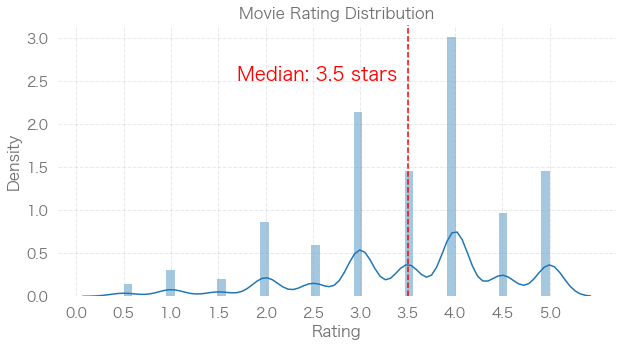

In [4]:
# Density plot of ratings
plt.figure(figsize=(10, 5))
sns.distplot(rest_df["rating"])
plt.axvline(rest_df["rating"].median(), color="r", linestyle="--")
plt.title("Movie Rating Distribution")
plt.xlabel("Rating")
plt.xticks(np.arange(0, 5.5, step=0.5))
plt.ylabel("Density")
plt.text(
    rest_df["rating"].median() - 1.8,
    2.5,
    f'Median: {rest_df["rating"].median()} stars',
    horizontalalignment="left",
    size="large",
    color="red",
    weight="semibold",
)
plt.show()

Most movies are rated rather highly.

### Number of ratings

#### Per movie

In [5]:
# Count the number of ratings received by each movie
num_ratings_movie = pd.DataFrame(
    rest_df.groupby("movieId").count()["rating"]
).reset_index()

# Add this information to the original data frame
df_movie_num = pd.merge(left=rest_df, right=num_ratings_movie, on="movieId")
df_movie_num.rename(
    columns={"rating_x": "rating", "rating_y": "numRatings"}, inplace=True
)

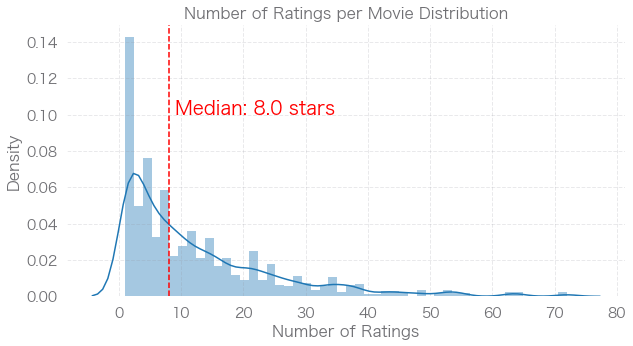

In [6]:
# Density plot of the number of ratings
plt.figure(figsize=(10, 5))
sns.distplot(df_movie_num["numRatings"])
plt.axvline(df_movie_num["numRatings"].median(), color="r", linestyle="--")
plt.title("Number of Ratings per Movie Distribution")
plt.xlabel("Number of Ratings")
plt.ylabel("Density")
plt.text(
    df_movie_num["numRatings"].median() + 1,
    0.1,
    f'Median: {df_movie_num["numRatings"].median()} stars',
    horizontalalignment="left",
    size="large",
    color="red",
    weight="semibold",
)
plt.show()

Most movies don't have many ratings.

#### Per user

In [7]:
# Count the number of ratings given by each user
num_ratings_user = pd.DataFrame(
    rest_df.groupby("userId").count()["rating"]
).reset_index()

# Add this information to the original data frame
df_user_num = pd.merge(left=rest_df, right=num_ratings_user, on="userId")
df_user_num.rename(
    columns={"rating_x": "rating", "rating_y": "numRatings"}, inplace=True
)

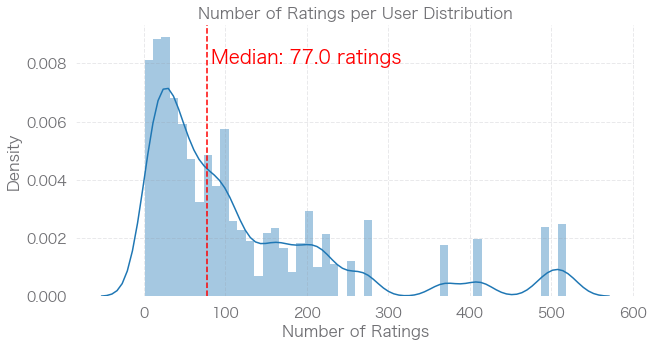

In [8]:
# Density plot of the number of ratings
plt.figure(figsize=(10, 5))
sns.distplot(df_user_num["numRatings"])
plt.axvline(df_user_num["numRatings"].median(), color="r", linestyle="--")
plt.title("Number of Ratings per User Distribution")
plt.xlabel("Number of Ratings")
plt.ylabel("Density")
plt.text(
    df_user_num["numRatings"].median() + 5,
    0.008,
    f'Median: {df_user_num["numRatings"].median()} ratings',
    horizontalalignment="left",
    size="large",
    color="red",
    weight="semibold",
)
plt.show()

Most users don't rate many movies. So data is sparse - so some algorithms are better and some are problematic.

### Rating vs. number of ratings

#### Per movie

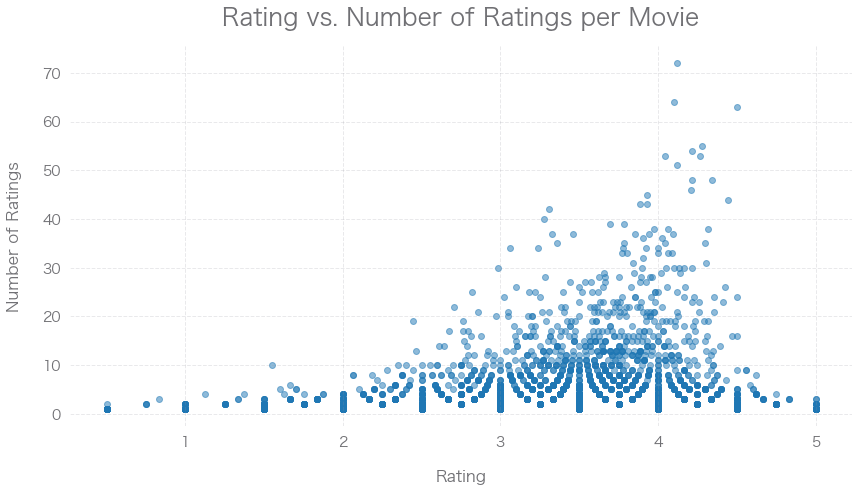

In [9]:
ratings_movie = pd.DataFrame()
ratings_movie["meanRating"] = df_movie_num.groupby("movieId")["rating"].mean().values
ratings_movie["numRatings"] = df_movie_num.groupby("movieId")["rating"].count().values


fig, ax = plt.subplots(figsize=(14, 7))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_title("Rating vs. Number of Ratings per Movie", fontsize=24, pad=20)
ax.set_xlabel("Rating", fontsize=16, labelpad=20)
ax.set_ylabel("Number of Ratings", fontsize=16, labelpad=20)

plt.scatter(ratings_movie["meanRating"], ratings_movie["numRatings"], alpha=0.5)
plt.show()

Highly rated movies also tend to be more popular.

#### Per user

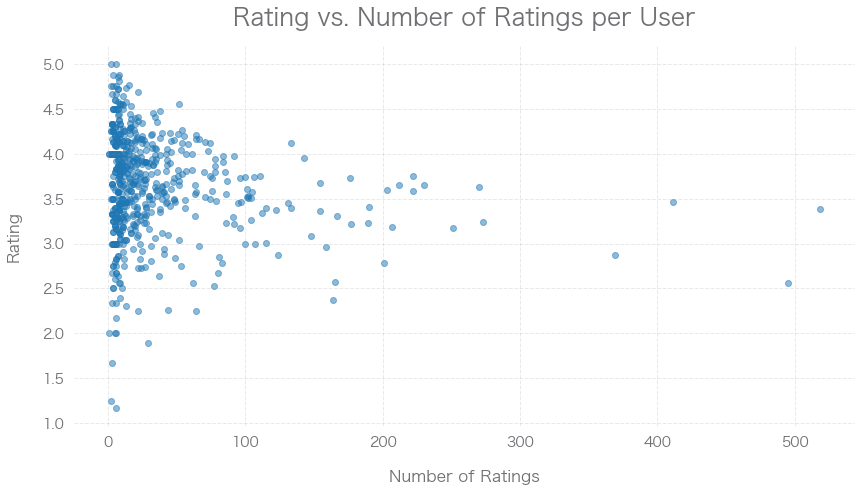

In [10]:
ratings_user = pd.DataFrame()
ratings_user["meanRating"] = df_user_num.groupby("userId")["rating"].mean().values
ratings_user["numRatings"] = df_user_num.groupby("userId")["rating"].count().values


fig, ax = plt.subplots(figsize=(14, 7))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_title("Rating vs. Number of Ratings per User", fontsize=24, pad=20)
ax.set_xlabel("Number of Ratings", fontsize=16, labelpad=20)
ax.set_ylabel("Rating", fontsize=16, labelpad=20)

plt.scatter(ratings_user["numRatings"], ratings_user["meanRating"], alpha=0.5)
plt.show()

Prolific users are close to the median.

# Build a recommender

## Hyperparameter tuning
Tune hyperparameters using the validation set.

In [11]:
# Hyperparameter space
param_grid = {
    "n_factors": [50, 100, 150],
    "n_epochs": [20, 30],
    "lr_all": [0.005, 0.01],
    "reg_all": [0.02, 0.1],
}

# Grid search through the space
gs = GridSearchCV(SVD, param_grid, measures=["rmse"], cv=3)

gs.fit(validation)

# Find best SVD++ estimator
params = gs.best_params["rmse"]

algo = SVD(
    n_factors=params["n_factors"],
    n_epochs=params["n_epochs"],
    lr_all=params["lr_all"],
    reg_all=params["reg_all"],
)

### Cross validation

In [12]:
# Evaluate the model
cross_validate(algo, rest, measures=["RMSE", "MAE"], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9113  0.9060  0.9083  0.9270  0.9150  0.9135  0.0074  
MAE (testset)     0.7034  0.7017  0.7016  0.7180  0.7051  0.7060  0.0061  
Fit time          1.98    2.00    1.97    1.99    1.98    1.98    0.01    
Test time         0.02    0.03    0.02    0.02    0.02    0.02    0.00    


{'test_rmse': array([0.91133088, 0.90603953, 0.90826298, 0.92703586, 0.91501917]),
 'test_mae': array([0.70336218, 0.70165384, 0.70164257, 0.71797851, 0.70513081]),
 'fit_time': (1.9782240390777588,
  1.9993271827697754,
  1.9674458503723145,
  1.9925200939178467,
  1.9801511764526367),
 'test_time': (0.02239680290222168,
  0.025297164916992188,
  0.02415609359741211,
  0.02255415916442871,
  0.0218658447265625)}

### Predict test data

In [13]:
# Train the algorithm on the train set
algo.fit(train)

# Predict ratings for the test set
predictions = algo.test(test)

# Compute RMSE
accuracy.rmse(predictions)

RMSE: 0.9110


0.9110112983452514

In [14]:
# Save the model for later use
dump.dump("best_svd", algo=algo)

## For a single user
Suppose we're interested in User #3. (Cambridge Spark [tutorial](https://blog.cambridgespark.com/tutorial-practical-introduction-to-recommender-systems-dbe22848392b))

In [15]:
# Load tuned SVD
_, svdtuned = dump.load("best_svd")

In [16]:
# List of all movie ID's
iids = data_df["movieId"].unique()

In [17]:
# List of movies rated by User #3
iids3 = data_df.loc[data_df["userId"] == 3, "movieId"]

# Remove movies already rated by User #3
iids_to_pred = np.setdiff1d(iids, iids3)

In [18]:
# Set ratings of unrated movies to 5 (arbitarily)
testset = [[3, iid, 5.0] for iid in iids_to_pred]

# Predict how User #3 would rate movies not yet watched
predictions = svdtuned.test(testset)

# Find top 10 movie that User #3 may like the best
pred_ratings = np.array([pred.est for pred in predictions])

top10 = np.argpartition(pred_ratings, -10)[-10:]  # Indices of top 10 ratings

iid_idx = iids_to_pred[top10]  # Corresponding movie ID's

iid_title = movies_df.loc[
    movies_df["movieId"].isin(iid_idx), "title"
].tolist()  # List of movie titles

print(f"Top 10 movies recommended for User #3: \n {iid_title}.")

Top 10 movies recommended for User #3: 
 ['Casino (1995)', 'Silence of the Lambs, The (1991)', 'Reservoir Dogs (1992)', 'Lawrence of Arabia (1962)', 'Harold and Maude (1971)', 'Great Escape, The (1963)', 'Raising Arizona (1987)', 'Life Is Beautiful (La Vita è bella) (1997)', 'Animal House (1978)', 'City of God (Cidade de Deus) (2002)'].
